In [38]:
from torch.utils.data import Dataset,DataLoader
import numpy as np
import os,glob,random
import pandas as pd
import torch
from scipy.misc import imread,imsave,imresize
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from math import ceil,floor
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

def show_image(pid,vid):
    data_dir='/scratch0/datasets/NYC3dcars/'
    root_dir='/scratch0/datasets/NYC3dcars/times-square-images/'
    photos=pd.read_pickle(os.path.join(data_dir,'nyc3dcars-csv/preprocessed_photos'))
    vehicles=pd.read_csv(os.path.join(data_dir,'nyc3dcars-csv/vehicles.csv'))
    vehicles.drop(vehicles.columns[[13,14]], axis=1, inplace=True)
    photos1=photos[['id', 'filename','width', 'height','roll','sees_ground', 'camera_height','test', 'dataset_id']]
    photos1 = photos1.rename(columns={'id': 'pid'})
    right_result=pd.merge(photos1, vehicles, how='inner', on='pid',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
    df=right_result.loc[right_result['pid'] == pid]
    filename=df['filename'].tolist()[0]
    print(filename)
    im=imread(os.path.join(root_dir,filename))
    
    df=df.loc[df['id']==vid]
    df.index = np.arange(0, len(df))
    x1,x2,y1,y2=df.loc[0,'x1'],df.loc[0,'x2'],df.loc[0,'y1'],df.loc[0,'y2']
    w,h,occ=df.loc[0,'width'],df.loc[0,'height'],df.loc[0,'occlusion']
    x1,y1,x2,y2=max(0,x1),max(0,y1),min(1,x2),min(1,y2)
    x1,y1,w1,h1,x2,y2=int(x1*w),int(y1*h),int((x2-x1)*w),int((y2-y1)*h),int(x2*w),int(y2*h)
#     fig,ax = plt.subplots(1)
#     ax.imshow(im)
#     rect = patches.Rectangle((x1,y1),w1,h1,linewidth=1,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
#     plt.show()
    im = cv2.rectangle(im,(x1,y1),(x2,y2),(255,0,0),5)
    print('occlusion: {0:3d}'.format(occ))
    return im

class NYC3dcars(Dataset):
    def __init__(self,root_dir='/scratch0/datasets/NYC3dcars/',training=0,size=512):
        super(NYC3dcars,self).__init__()
        self.size=size
        self.root_dir=root_dir
        self.training=training
        self.complete_images_path=os.path.join(self.root_dir,'times-square-images/')
        self.datasets=pd.read_csv(os.path.join(self.root_dir,'nyc3dcars-csv/datasets.csv'))
        self.photos=pd.read_pickle(os.path.join(self.root_dir,'nyc3dcars-csv/preprocessed_photos'))
        self.vehicles=pd.read_csv(os.path.join(self.root_dir,'nyc3dcars-csv/vehicles.csv'))
        self.vehicle_types=pd.read_csv(os.path.join(self.root_dir,'nyc3dcars-csv/vehicle_types.csv'))
        self.vehicles.drop(self.vehicles.columns[[13,14]], axis=1, inplace=True)
        self.photos1=self.photos[['id', 'filename','width', 'height','roll','sees_ground', 'camera_height','test', 'dataset_id']]
        self.photos1 = self.photos1.rename(columns={'id': 'pid'})
        self.right_result=pd.merge(self.photos1, self.vehicles, how='inner', on='pid',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
        self.right_result['area_bb']=self.right_result.apply(lambda row: (min(row.x2,1)-max(row.x1,0))*(min(row.y2,1)-max(row.y1,0)), axis=1)
        k=0.2
        threshold=k*self.right_result['area_bb'].mean()
        self.right_result=self.right_result.loc[self.right_result['area_bb']>=threshold]
        # By this point we would have selected all the images in times_square_images with atleast a vehicle that has decent proportion of area in the image it belongs

        self.right_result_ts=self.right_result.sample(frac=1,random_state=250).reset_index(drop=True) # shuffle all the rows in a consistent fashion
        self.right_result1=self.right_result_ts.loc[self.right_result_ts['occlusion']<=1] # corrupt data with little occluded cars
        self.right_result1.index = np.arange(0, len(self.right_result1))

        if(self.training):
            self.right_result_ts=self.right_result_ts.iloc[:len(self.right_result_ts)-150,:]
            self.right_result_ts.index = np.arange(0, len(self.right_result_ts))
        else:
            self.right_result_ts=self.right_result_ts.iloc[-150:,:]
            self.right_result_ts.index = np.arange(0, len(self.right_result_ts))

        num_rows=self.right_result1.shape[0]
        print(num_rows)
        theta=[self.right_result1.loc[i,'view_theta'] for i in range(0,num_rows)]
        phi=[self.right_result1.loc[i,'view_phi'] for i in range(0,num_rows)]
        x=[self.right_result1.loc[i,'x'] for i in range(0,num_rows)]
        z=[self.right_result1.loc[i,'z'] for i in range(0,num_rows)]
        th=[self.right_result1.loc[i,'theta'] for i in range(0,num_rows)]
        occ=[self.right_result1.loc[i,'occlusion'] for i in range(0,num_rows)]
        cam_height=[self.right_result1.loc[i,'camera_height'] for i in range(0,num_rows)]

        self.filenames=[self.right_result1.loc[i,'filename'] for i in range(0,num_rows)]
        self.pids=[self.right_result1.loc[i,'pid'] for i in range(0,num_rows)]
        self.vids=[self.right_result1.loc[i,'id'] for i in range(0,num_rows)]

        X=np.zeros((num_rows,6),dtype=np.float32)
        for i in range(0,num_rows):
            X[i,0]=theta[i]
            X[i,1]=phi[i]
            X[i,2]=x[i]
            X[i,3]=z[i]
            X[i,4]=th[i]
            # X[i,5]=occ[i]
            X[i,5]=cam_height[i]

        self.nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(X)
        # distances, indices = nbrs.kneighbors(X)
    def __len__(self):
        return len(self.right_result_ts)

    def __getitem__(self,idx):
        filename=self.right_result_ts.loc[idx,'filename']
        pid=self.right_result_ts.loc[idx,'pid']
        vid=self.right_result_ts.loc[idx,'id']

        img=show_image(pid,vid)
        fig=plt.figure()
        fig.set_size_inches(18.5,10.5)
        fig.add_subplot(1,4,1).imshow(img)

        input=imread(os.path.join(self.complete_images_path,filename))
        input_resized=resize(input,(self.size,self.size))
        x1,y1,x2,y2=self.right_result_ts.loc[idx,'x1'],self.right_result_ts.loc[idx,'y1'],self.right_result_ts.loc[idx,'x2'],self.right_result_ts.loc[idx,'y2']
        x1,y1,x2,y2=max(0,x1),max(0,y1),min(1,x2),min(1,y2)
        w,h=self.right_result_ts.loc[idx,'width'],self.right_result_ts.loc[idx,'height']
        # bb_x1,bb_y1,bb_w,bb_h=int(x1*w),int(y1*h),int((x2-x1)*w),int((y2-y1)*h)
        # bb_x1n,bb_y1n,bb_wn,bb_hn=int(bb_x1*self.size.0/w),int(bb_y1*self.size.0/h),int(bb_w*self.size.0/w),int(bb_h*self.size.0/h)
        bb_x1,bb_y1,bb_x2,bb_y2 = int(floor(x1*self.size)),int(floor(y1*self.size)),int(ceil(x2*self.size)),int(ceil(y2*self.size)) 
        bb_x1,bb_y1,bb_x2,bb_y2=max(bb_x1,0),max(bb_y1,0),min(bb_x2,self.size-1),min(bb_y2,self.size-1) # since we are limiting our input image to self.sizexself.size
        bb_w,bb_h=(bb_x2-bb_x1)+1,(bb_y2-bb_y1)+1

        chip=input_resized[bb_y1:(bb_y2+1),bb_x1:(1+bb_x2),:]
        # chip_resized=resize(chip,(256,256))
        # chip_resized/=255.0

        box=np.ones((chip.shape[0],chip.shape[1],1),dtype=np.float32)
        mask=np.zeros((self.size,self.size,1),dtype=np.float32)
        mask[bb_y1:(bb_y2+1),bb_x1:(1+bb_x2),:]=box
        inv_mask=np.ones((self.size,self.size,1),dtype=np.float32)-mask
        input_new=input_resized*inv_mask
        input_masked=input_new # for the sake of plotting
#         input_new/=255.0
        # imsave('input_'+str(idx)+'.jpg',input_new)

        input=torch.from_numpy(input_new)
        input=input.type(torch.FloatTensor)
        input=torch.cat((torch.from_numpy(mask).type(torch.FloatTensor),input),dim=2)
        input=input.permute(2,0,1)


        th,x,z=self.right_result_ts.loc[idx,'theta'],self.right_result_ts.loc[idx,'x'],self.right_result_ts.loc[idx,'z']
        cam_height,occ=self.right_result_ts.loc[idx,'camera_height'],self.right_result_ts.loc[idx,'occlusion']
        theta,phi=self.right_result_ts.loc[idx,'view_theta'],self.right_result_ts.loc[idx,'view_phi']
        X=np.zeros((1,6),dtype=np.float32)
        X[0,0]=theta
        X[0,1]=phi
        X[0,2]=x
        X[0,3]=z
        X[0,4]=th
        # X[0,5]=occ
        X[0,5]=cam_height

        _,indices=self.nbrs.kneighbors(X)
        if(self.training):
            pick=random.randint(0,5)
        else:
            pick=1
        idx_new=indices[0,pick]

        pid_new=self.pids[idx_new]
        vid_new=self.vids[idx_new]
        # filename_new_resized=str(pid_new)+'_'+str(vid_new)+'_resized.jpg'
        filename_new=str(pid_new)+'_'+str(vid_new)+'.jpg'
        # new_chip=imread(os.path.join(self.root_dir,'all_cars/resized',filename_new_resized))
        new_chip_original=imread(os.path.join(self.root_dir,'all_cars/original/',filename_new))
        new_chip=resize(new_chip_original,(bb_h,bb_w))
        second_image=np.zeros((self.size,self.size,3),dtype=np.float32)
        second_image[bb_y1:(bb_y2+1),bb_x1:(1+bb_x2),:]=new_chip

        fig.add_subplot(1,4,2).imshow(new_chip)
        fig.add_subplot(1,4,3).imshow(second_image)
        fig.add_subplot(1,4,4).imshow(np.add(second_image,input_masked))
        plt.show()

#         second_image/=255.0
        # imsave('second_image_'+str(idx)+'.jpg',second_image)
        
        new_chip=torch.from_numpy(second_image)
        new_chip=new_chip.type(torch.FloatTensor)
        new_chip=torch.cat((torch.from_numpy(mask).type(torch.FloatTensor),new_chip),dim=2)
        new_chip=new_chip.permute(2,0,1)

        # chip=torch.from_numpy(chip_resized)
        # chip=chip.type(torch.FloatTensor)
        # chip=chip.permute(2,0,1)

        gt=input_resized
#         gt/=255.0
        gt=torch.from_numpy(gt)
        gt=gt.type(torch.FloatTensor)
        gt=gt.permute(2,0,1)
        if(self.training):
            return input,new_chip,gt
        else:
            return input,new_chip,gt,pid,vid,os.path.join(self.complete_images_path,filename),filename

965
2537
images/2862968650_ee9bd15851_o.jpg


/scratch0/anaconda2/envs/torch_py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/scratch0/anaconda2/envs/torch_py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


occlusion:   3


/scratch0/anaconda2/envs/torch_py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:175: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


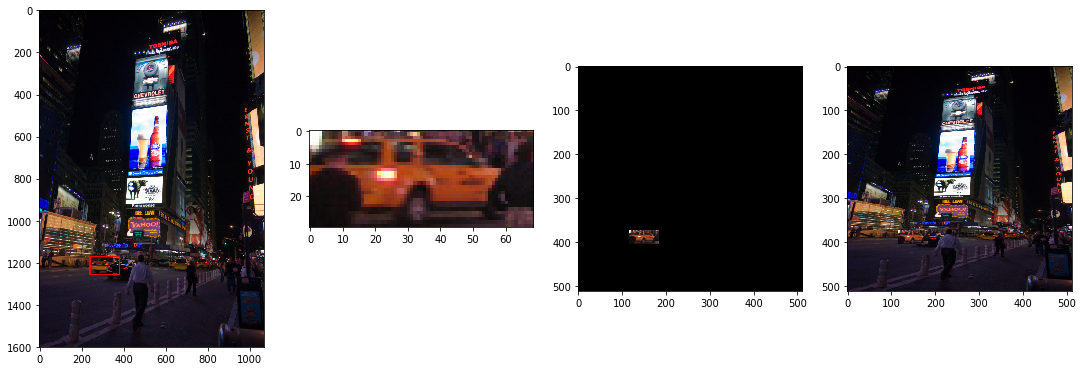

images/2060860062_110945d926_o.jpg
occlusion:   3


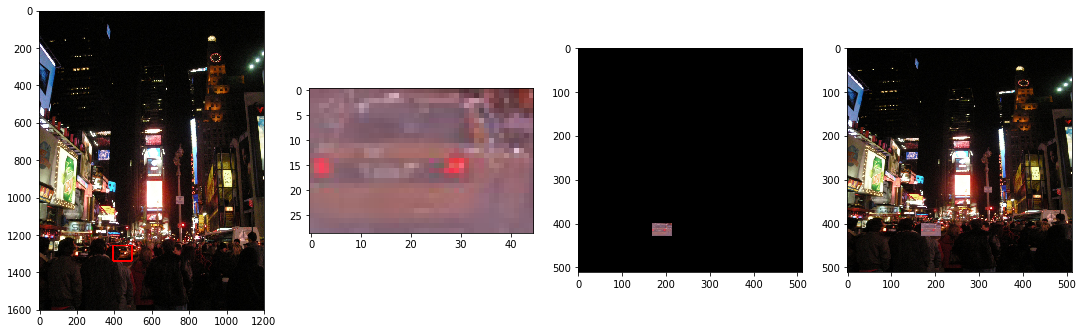

images/179493253_6cc28c6b62_o.jpg
occlusion:   1


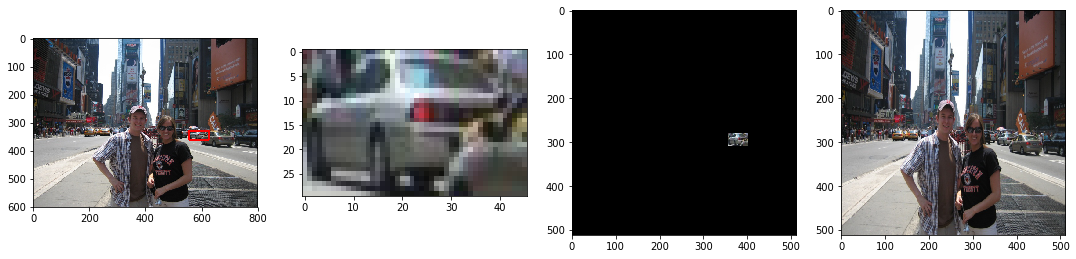

images/3333786341_9a6e932500_o.jpg
occlusion:   3


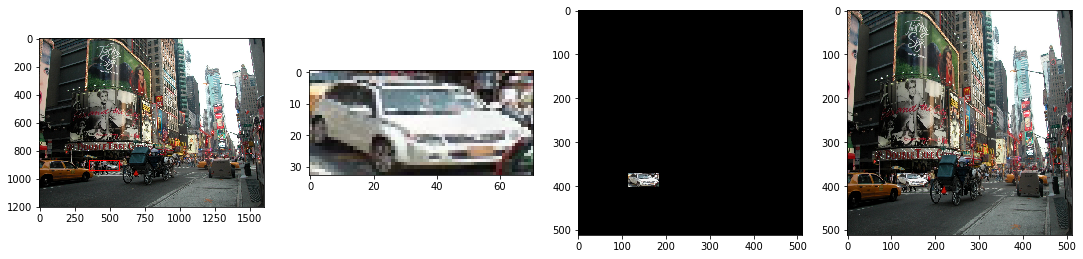

images/174178401_417f7fc7e5_o.jpg
occlusion:   4


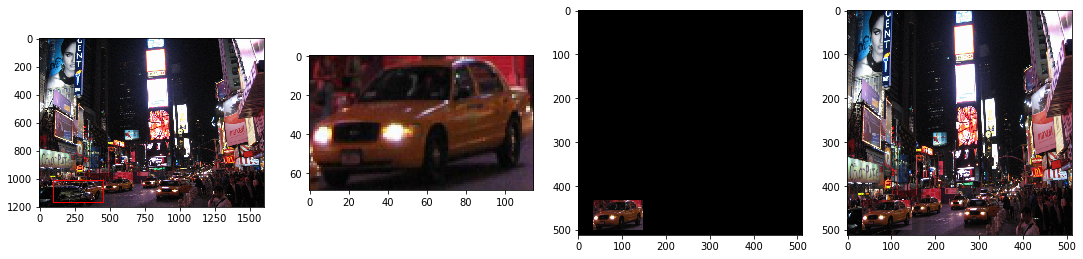

images/1440212270_a9568fdbd3_o.jpg
occlusion:   4


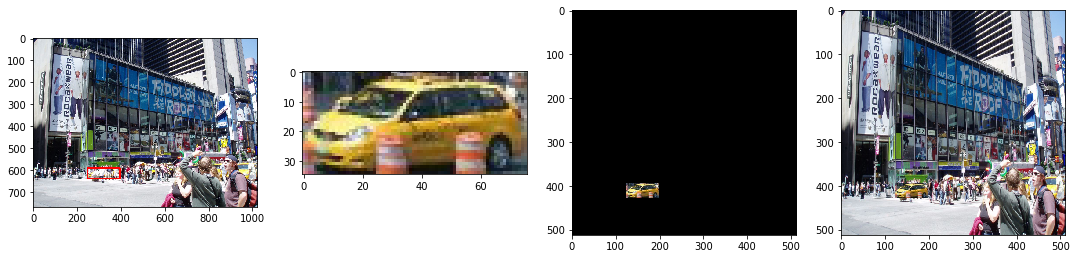

images/2935946334_10ab84cbb7_o.jpg
occlusion:   1


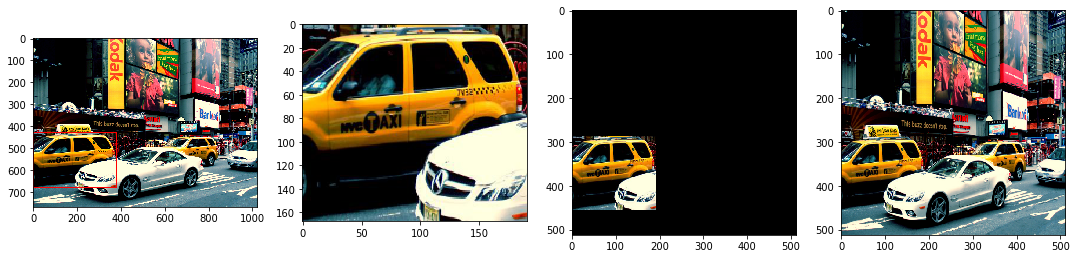

images/3833473518_2f467124fe_o.jpg
occlusion:   0


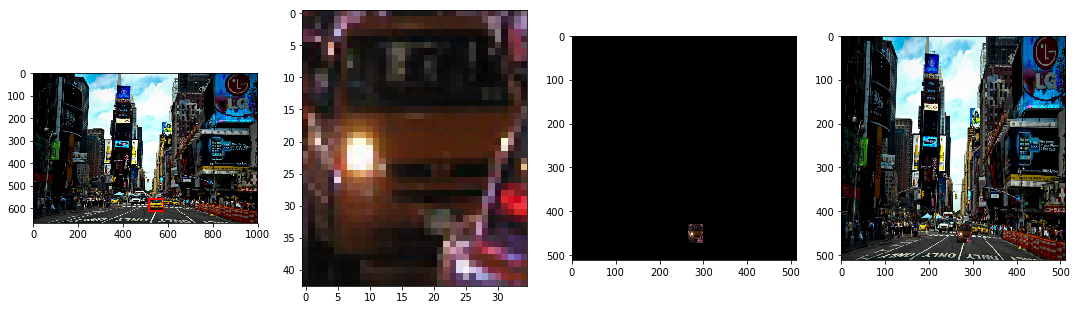

images/1022198805_9fd894ba39_o.jpg
occlusion:   2


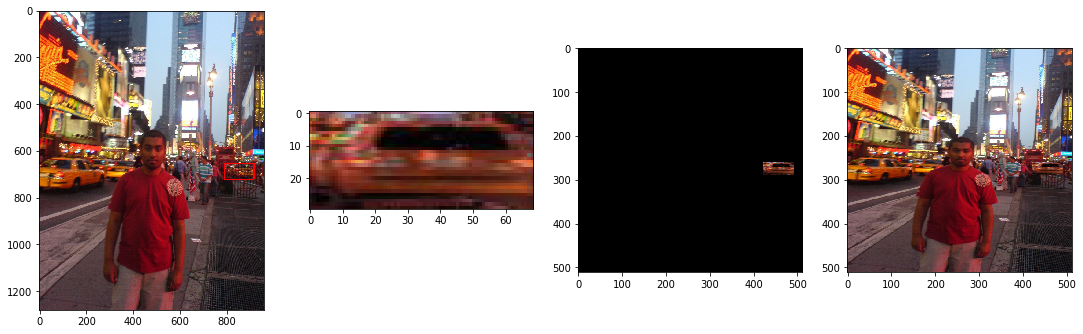

images/3168470673_1e04f686a9_o.jpg
occlusion:   2


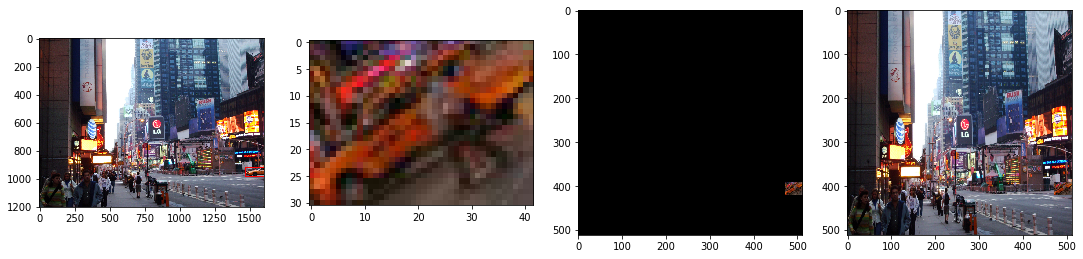

images/421946414_2aefb3ebf4_o.jpg
occlusion:   1


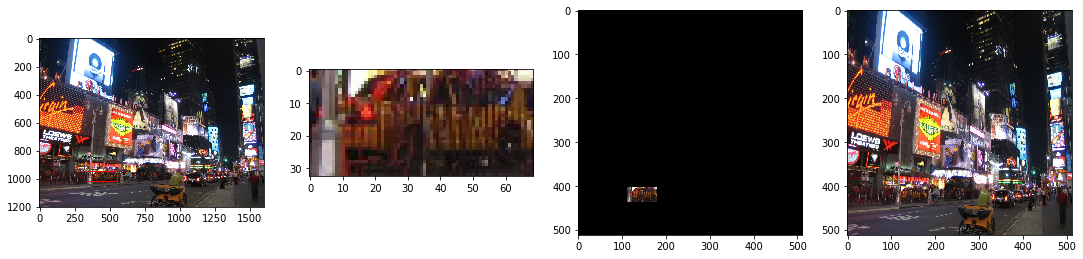

images/2930739373_154356b340_o.jpg
occlusion:   3


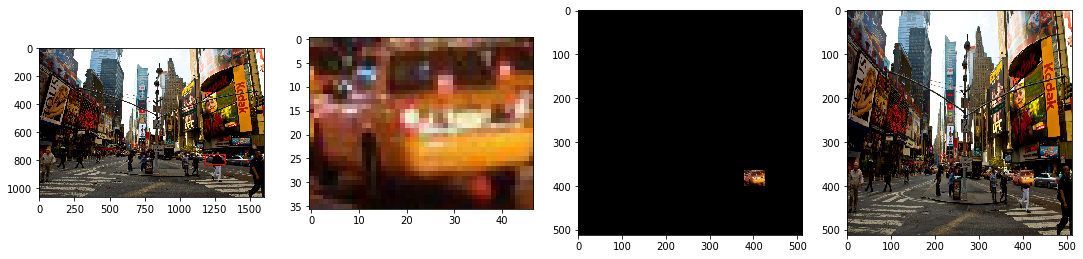

images/766396047_811ae726c8_o.jpg
occlusion:   1


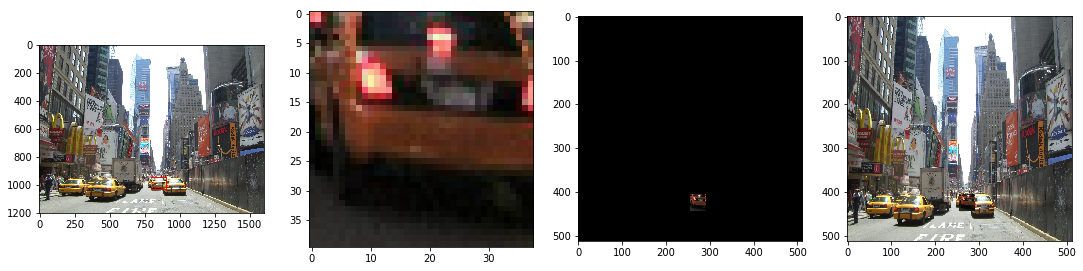

images/835114640_4786a04f03_o.jpg
occlusion:   0


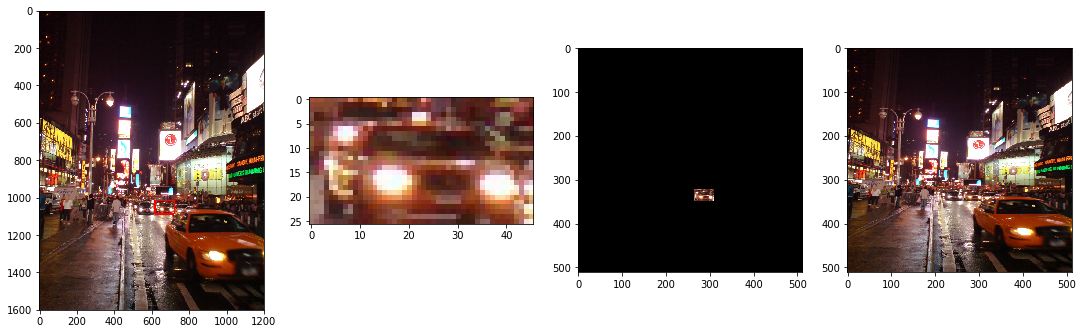

images/3037089688_bdf1f8200d_o.jpg
occlusion:   0


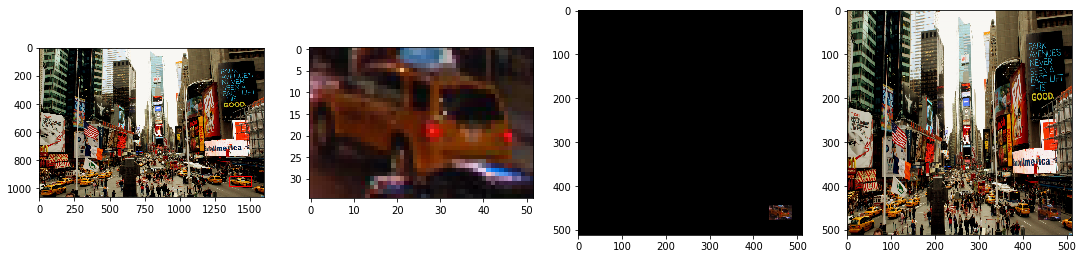

In [39]:
train_dataset=NYC3dcars(training=1)
print(train_dataset.__len__())
# val_dataset=NYC3dcars()
# print(val_dataset.__len__())
train_dataloader=DataLoader(train_dataset,batch_size=5,shuffle=False)
# # # val_dataloader=DataLoader(val_dataset,batch_size=10,shuffle=False)
for i,data in enumerate(train_dataloader):
	if(i==2):
		break
# 	input,new_chip,gt=data
# 	print(input.shape,new_chip.shape,gt.shape)	
# 	# print(filename[0])
# 	# k=input[0,1:,:,:].permute(1,2,0).cpu().numpy()
# 	# print(k.shape)
# 	# imsave('test_input.png',k)